# Предсказание температуры стали

# Описание задачи

    Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

    Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри
    его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры
    графитовыми электродами. Они установлены в крышке ковша.

    Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.
    Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через
    специальный трайб-аппарат (англ. tribe, «масса»).

    Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом
    температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его
    перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной
    температуры плавки.

    Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый
    продукт выходит в виде заготовок-слябов (англ. slab, «плита»).



# Описание данных

Данные состоят из файлов, полученных из разных источников:

    - data_arc.csv — данные об электродах;
    - data_bulk.csv — данные о подаче сыпучих материалов (объём);
    - data_bulk_time.csv — данные о подаче сыпучих материалов (время);
    - data_gas.csv — данные о продувке сплава газом;
    - data_temp.csv — результаты измерения температуры;
    - data_wire.csv — данные о проволочных материалах (объём);
    - data_wire_time.csv — данные о проволочных материалах (время).
    
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.



# План работы

    1) Описание проекта
    2) Анализ и подготовка данных
        a) выгрузка данных
        b) анализ данных
        c) описание данных
    3) Предобработка данных
        a) Проверка типов данных
        b) Работа с пропусками
    4) Подготовка данных
        a) Формирование итоговых датафреймов
        b) Формирование целевого признака
        c) Формирвоание обучающих и тест выборок
    5) Обучение 2-4 моделей
    6) Тестирование лучшей модели
    7) Вывод

# Цель проекта

    Построение подели которая предскажет температуру стали.

    Вопросов к заказчику не имею. 

### Импорт библиотек ⬇

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## Изучение и подготовка данных

### arc

In [7]:
df1 = '/datasets/data_arc_new.csv'
df2 = 'data_arc_new.csv'

if os.path.exists(df1):
    df_arc = pd.read_csv(df1, parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
elif os.path.exists(df2):
    df_arc = pd.read_csv(df2, parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])

In [8]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [9]:
df_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


In [10]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [11]:
df_arc['key'].value_counts()

key
2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: count, Length: 3214, dtype: int64

    Значения столбца key - повторяются. Скорее всего они означают количество обработак материала за одну программу (от
    начала нагрева до конца нагрева)

    Посмотрим как выглядят на графике значения нагрева во время Активной мощности ⬇

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

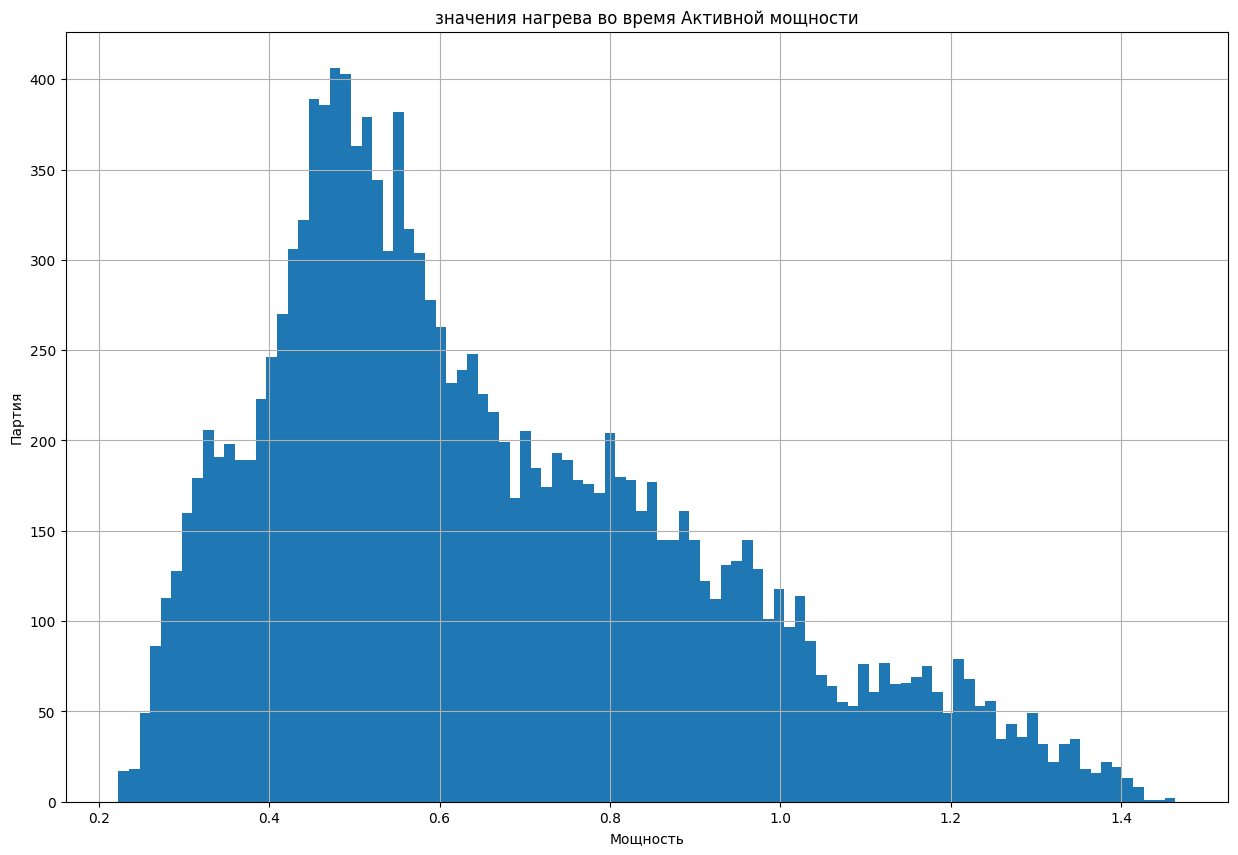

In [12]:
display(df_arc['Активная мощность'].describe())
df_arc['Активная мощность'].hist(bins=100, figsize=(15,10))
plt.title('значения нагрева во время Активной мощности')
plt.xlabel('Мощность')
plt.ylabel('Партия');

    Значения мощности распределены нормально. Есть небольшие выбросы, думаю можно списать их на скачки напряжения

In [13]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


    Также видим отрицательное значение в столбце "Реактивная мощность". При предобработке данных нужно будет удалить всю партию.

### bulk

In [14]:
df1 = '/datasets/data_bulk_new.csv'
df2 = 'data_bulk_new.csv'

if os.path.exists(df1):
    df_bulk = pd.read_csv(df1)
elif os.path.exists(df2):
    df_bulk = pd.read_csv(df2)

In [15]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
df_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [18]:
df_bulk['key'].value_counts()

key
1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: count, Length: 3129, dtype: int64

    Значения столбца key в этой таблице уникальные для каждой строки

    На данный момент не видно есть ли остальны значения в колонках. Выведем их ⬇

В стобце Bulk 8 только одно значение

### bulk_time

In [19]:
df1 = '/datasets/data_bulk_time_new.csv'
df2 = 'data_bulk_time_new.csv'

if os.path.exists(df1):
    df_bulk_time = pd.read_csv(df1, parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                            'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11',
                                            'Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
elif os.path.exists(df2):
    df_bulk_time = pd.read_csv(df2, parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                            'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11',
                                            'Bulk 12','Bulk 13','Bulk 14','Bulk 15'])

In [20]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [21]:
df_bulk_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaT,NaT,NaT,2019-05-03 13:57:27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:48:52,NaT,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaT,NaT,NaT,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:41:26,NaT,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:17:58,NaT,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:03:08,NaT,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:38:11,NaT,2019-05-03 16:34:24,2019-05-03 16:29:56


In [23]:
df_bulk_time['key'].value_counts()

key
1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: count, Length: 3129, dtype: int64

    Значения столбца key в этой таблице уникальные для каждой строки. Значения связаны с таблицей
    "date_bulk_new"

### gas

In [24]:
df1 = '/datasets/data_gas_new.csv'
df2 = 'data_gas_new.csv'

if os.path.exists(df1):
    df_gas = pd.read_csv(df1)
elif os.path.exists(df2):
    df_gas = pd.read_csv(df2)

In [25]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [26]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [27]:
df_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [28]:
df_gas['key'].value_counts()

key
1       1
2166    1
2156    1
2157    1
2158    1
       ..
1086    1
1087    1
1088    1
1089    1
3241    1
Name: count, Length: 3239, dtype: int64

    Значения столбца key в этой таблице уникальные для каждой строки.

### temp

In [29]:
df1 = '/datasets/data_temp_new.csv'
df2 = 'data_temp_new.csv'

if os.path.exists(df1):
    df_temp = pd.read_csv(df1, parse_dates = ['Время замера'])
elif os.path.exists(df2):
    df_temp = pd.read_csv(df2, parse_dates = ['Время замера'])

In [30]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


    Видим что некоторые значения в столбце "Температура" не заполнены

In [31]:
df_temp.describe()

,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381


In [32]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [33]:
df_temp['key'].value_counts()

key
2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: count, Length: 3216, dtype: int64

    Значения столбца key - повторяются. Скорее всего они означают количество обработак материала за одну программу.

    Посмотрим температуру на графике ⬇

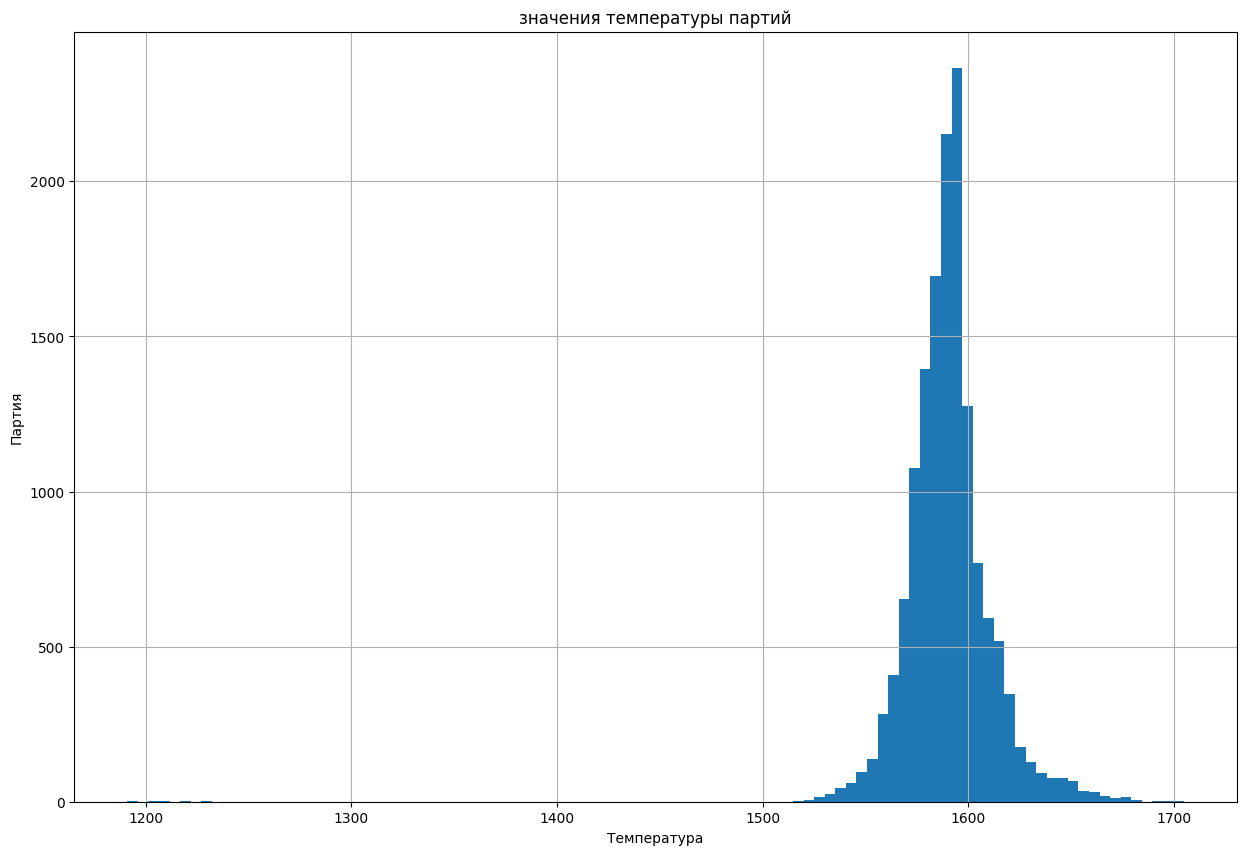

In [34]:
df_temp['Температура'].hist(bins=100, figsize=(15,10))
plt.title('значения температуры партий')
plt.xlabel('Температура')
plt.ylabel('Партия');

    Значения температур распределены нормально. 

    Температура плаваления стали - 1450 градусов. Проверим встречаются ли в данных такие значения ⬇

In [35]:
df_temp[df_temp['Температура'] < 1450]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


    Видим 5 значений у которых температура ниже 1450град. Возможно это ошибки приборов. Но для обучения нам нужны правильные данные. В предобработке данных нужно удалить эти партии

### wire

In [36]:
df1 = '/datasets/data_wire_new.csv'
df2 = 'data_wire_new.csv'

if os.path.exists(df1):
    df_wire = pd.read_csv(df1)
elif os.path.exists(df2):
    df_wire = pd.read_csv(df2)

In [37]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [38]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [39]:
df_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_wire['key'].value_counts()

key
1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: count, Length: 3081, dtype: int64

    Значения столбца key в этой таблице уникальные для каждой строки

    На данный момент не видно есть ли остальны значения в колонках. Выведем их ⬇

В стобце Wire 5 только одно значение

### wire_time

In [41]:
df1 = '/datasets/data_wire_time_new.csv'
df2 = 'data_wire_time_new.csv'

if os.path.exists(df1):
    df_wire_time = pd.read_csv(df1, parse_dates = ['Wire 1', 'Wire 2', 'Wire 3',
                                            'Wire 4', 'Wire 5', 'Wire 6',
                                            'Wire 7', 'Wire 8', 'Wire 9'])
elif os.path.exists(df2):
    df_wire_time = pd.read_csv(df2, parse_dates = ['Wire 1', 'Wire 2', 'Wire 3',
                                            'Wire 4', 'Wire 5', 'Wire 6',
                                            'Wire 7', 'Wire 8', 'Wire 9'])

In [42]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [43]:
df_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT
6,7,2019-05-03 14:18:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,8,2019-05-03 15:01:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### Вывод

    1) Столбцы имеют рызные языки. Имена столбцов нужно превести к общепринятому виду (латиницей, нижним регистром,
    без пробелов).

    2) Все столбцах с датами при выгрузке мы перевели в формат datetime.

    3) Целевым признаком возьмём последний замер температуры в data_temp_new

    4) Пропуски в столбцах могут быть по разным причинам: ошибка переноса, ошибка датчика или же просто остутсвие
    необходимости в проведении действия (нагрев, добавка присадок и пр.)

    5) Данные нужно будет сгрупировать по номеру key.

## Предобработка данных

    Приведем столбцы в стандартный вид

In [45]:
df_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']

df_bulk.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

df_bulk_time.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                    'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

df_gas.columns = ['key', 'gas_1']

df_temp.columns = ['key', 'time','temp']

df_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

df_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

    Т.к. целевым признаком будет последний замер температуры, мы также видим что значения key в этой таблице повторяются.
    Тогда создадим переменную, которая будет отвечать за количество итераций в партии.

In [46]:
iter = df_temp['key'].value_counts()
iter = iter.sort_index()
print(iter)
iter.loc[2]

key
1       6
2       5
3       6
4       5
5       5
       ..
3237    6
3238    4
3239    9
3240    6
3241    6
Name: count, Length: 3216, dtype: int64


5

    Уберём отрицательные значения в data_arc_new

In [47]:
display(df_arc[df_arc['reactive_power'] < 0])

,key,start_time,end_time,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [48]:
display(df_arc[df_arc['key'] == 2116])

,key,start_time,end_time,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [49]:
df_arc = df_arc.query('key != 2116')

In [50]:
display(df_temp[df_temp['key'] == 2116])

,key,time,temp
11877,2116,2019-07-28 02:07:02,1579.0
11878,2116,2019-07-28 02:13:00,1574.0
11879,2116,2019-07-28 02:21:58,1578.0
11880,2116,2019-07-28 02:29:01,1575.0
11881,2116,2019-07-28 02:35:36,1578.0


In [51]:
df_temp = df_temp.query('key != 2116')

    Уберём значения температуры ниже 1450град. в data_temp_new

In [52]:
display(df_temp[df_temp['temp'] < 1450])

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [53]:
display(df_temp[df_temp['key'] == 867])
display(df_temp[df_temp['key'] == 1214])
display(df_temp[df_temp['key'] == 1619])
display(df_temp[df_temp['key'] == 2052])
display(df_temp[df_temp['key'] == 2561])

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


,key,time,temp
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0
6786,1214,2019-06-18 08:31:10,1608.0
6787,1214,2019-06-18 08:43:56,1591.0


,key,time,temp
9050,1619,2019-07-03 02:34:41,1218.0
9051,1619,2019-07-03 02:39:29,1623.0
9052,1619,2019-07-03 02:43:59,1590.0


,key,time,temp
11495,2052,2019-07-25 08:49:15,1227.0
11496,2052,2019-07-25 08:54:39,1592.0
11497,2052,2019-07-25 09:03:59,1590.0
11498,2052,2019-07-25 09:07:19,1591.0
11499,2052,2019-07-25 09:20:11,1515.0
11500,2052,2019-07-25 09:27:03,1592.0


,key,time,temp
14283,2561,2019-08-12 18:49:29,1204.0
14284,2561,2019-08-12 18:59:23,NaN
14285,2561,2019-08-12 19:06:26,NaN
14286,2561,2019-08-12 19:11:13,NaN
14287,2561,2019-08-12 19:17:08,NaN
14288,2561,2019-08-12 19:21:45,NaN


In [54]:
df_temp = df_temp.query('key != 867')
df_temp = df_temp.query('key != 1214')
df_temp = df_temp.query('key != 1619')
df_temp = df_temp.query('key != 2052')
df_temp = df_temp.query('key != 2561')

In [55]:
display(df_arc[df_arc['key'] == 867])
display(df_arc[df_arc['key'] == 1214])
display(df_arc[df_arc['key'] == 1619])
display(df_arc[df_arc['key'] == 2052])
display(df_arc[df_arc['key'] == 2561])

,key,start_time,end_time,active_power,reactive_power
4028,867,2019-06-06 08:03:49,2019-06-06 08:06:04,1.362161,0.948663
4029,867,2019-06-06 08:19:02,2019-06-06 08:21:37,0.520198,0.391826
4030,867,2019-06-06 08:22:48,2019-06-06 08:23:47,0.558775,0.361147
4031,867,2019-06-06 08:25:21,2019-06-06 08:27:11,0.525132,0.411021
4032,867,2019-06-06 08:29:59,2019-06-06 08:33:08,0.661064,0.578344
4033,867,2019-06-06 08:36:59,2019-06-06 08:41:13,0.365236,0.292677
4034,867,2019-06-06 08:43:12,2019-06-06 08:44:19,0.852855,0.620585


,key,start_time,end_time,active_power,reactive_power
5583,1214,2019-06-18 08:01:13,2019-06-18 08:02:43,0.460792,0.303613
5584,1214,2019-06-18 08:18:06,2019-06-18 08:23:35,1.177492,0.971594
5585,1214,2019-06-18 08:31:20,2019-06-18 08:32:22,0.338146,0.288641


,key,start_time,end_time,active_power,reactive_power
7446,1619,2019-07-03 02:34:51,2019-07-03 02:37:08,0.429974,0.295056
7447,1619,2019-07-03 02:39:39,2019-07-03 02:41:28,0.534904,0.487239


,key,start_time,end_time,active_power,reactive_power
9459,2052,2019-07-25 08:49:25,2019-07-25 08:50:57,0.492488,0.323616
9460,2052,2019-07-25 08:54:49,2019-07-25 08:59:14,0.376932,0.331312
9461,2052,2019-07-25 09:04:09,2019-07-25 09:05:17,0.978495,0.797917
9462,2052,2019-07-25 09:07:29,2019-07-25 09:09:40,0.577510,0.402109
9463,2052,2019-07-25 09:20:21,2019-07-25 09:21:38,0.474643,0.422623


,key,start_time,end_time,active_power,reactive_power
11745,2561,2019-08-12 18:49:39,2019-08-12 18:52:39,0.780120,0.547868
11746,2561,2019-08-12 18:59:33,2019-08-12 19:02:56,1.040331,0.755206
11747,2561,2019-08-12 19:06:36,2019-08-12 19:09:41,0.785953,0.526555
11748,2561,2019-08-12 19:11:23,2019-08-12 19:15:47,0.734681,0.462343
11749,2561,2019-08-12 19:17:18,2019-08-12 19:18:18,0.971237,0.663411


In [56]:
df_arc = df_arc.query('key != 867')
df_arc = df_arc.query('key != 1214')
df_arc = df_arc.query('key != 1619')
df_arc = df_arc.query('key != 2052')
df_arc = df_arc.query('key != 2561')

    Уберём партии где был только один замер температуры

In [57]:
df_temp['key'].value_counts()

key
2108    17
1689    16
1513    16
2567    15
322     14
        ..
2194     2
661      2
1281     2
279      1
195      1
Name: count, Length: 3210, dtype: int64

In [58]:
display(df_temp[df_temp['key'] == 279])
display(df_temp[df_temp['key'] == 195])

,key,time,temp
1549,279,2019-05-14 10:13:01,1603.0


,key,time,temp
1105,195,2019-05-11 00:01:36,1583.0


In [59]:
df_temp = df_temp.query('key != 279')
df_temp = df_temp.query('key != 195')

In [60]:
df_temp.reset_index(drop= True , inplace= True)

In [61]:
df_arc.reset_index(drop= True , inplace= True)

    По сколько некоторых key нет в data_temp_new, мы не можем взять 'key'  как индекс.

    Сделаем чтобы бралась последняя итерация партии и проверялось есть ли у этой итерации замер температуры,
    если нет, то берем все 'key' кроме этого

In [62]:
s = -1 
k = 0
key_df_temp = set()
for key in df_temp.key.unique():
    s = s + iter.loc[key]
    if (df_temp.loc[s]['time'] == df_temp[df_temp["key"] == key]['time'].max()):
        k = k + 1
        key_df_temp.add(key)
    if np.isnan(df_temp.loc[s].temp) == True: 
        df_temp = df_temp.loc[df_temp['key'] != key]
        df_arc = df_arc.loc[df_arc['key'] != key]
        df_gas = df_gas.loc[df_gas['key'] != key]
        df_bulk = df_bulk.loc[df_bulk['key'] != key]
        df_wire = df_wire.loc[df_wire['key'] != key]
        df_wire_time = df_wire_time.loc[df_wire_time['key'] != key]
        df_bulk_time = df_bulk_time.loc[df_bulk_time['key'] != key]
print(k)

3208


In [63]:
df_arc.isna().sum()

key               0
start_time        0
end_time          0
active_power      0
reactive_power    0
dtype: int64

In [64]:
df_temp.isna().sum()

key     0
time    0
temp    0
dtype: int64

In [65]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11428 entries, 0 to 11427
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             11428 non-null  int64         
 1   start_time      11428 non-null  datetime64[ns]
 2   end_time        11428 non-null  datetime64[ns]
 3   active_power    11428 non-null  float64       
 4   reactive_power  11428 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 535.7 KB


In [66]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13898 entries, 0 to 13897
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     13898 non-null  int64         
 1   time    13898 non-null  datetime64[ns]
 2   temp    13898 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.3 KB


    Сделаем функцию для поиска пропусков

In [67]:
def show_i(df):
    print('Количество пропусков в каждом столбце')    
    print(df.isna().mean())

    Также заполним пропуски нулями

In [68]:
show_i(df_bulk)
df_bulk = df_bulk.fillna(0)

Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917393
bulk_2     0.994604
bulk_3     0.599419
bulk_4     0.661685
bulk_5     0.977999
bulk_6     0.815691
bulk_7     0.994188
bulk_8     0.999585
bulk_9     0.994604
bulk_10    0.940639
bulk_11    0.946036
bulk_12    0.218348
bulk_13    0.994188
bulk_14    0.112495
bulk_15    0.288501
dtype: float64


In [69]:
show_i(df_bulk_time)
df_bulk_time = df_bulk_time.fillna(0)

Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917393
bulk_2     0.994604
bulk_3     0.599419
bulk_4     0.661685
bulk_5     0.977999
bulk_6     0.815691
bulk_7     0.994188
bulk_8     0.999585
bulk_9     0.994604
bulk_10    0.940639
bulk_11    0.946036
bulk_12    0.218348
bulk_13    0.994188
bulk_14    0.112495
bulk_15    0.288501
dtype: float64


In [70]:
show_i(df_wire)
df_wire = df_wire.fillna(0)

Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010110
wire_2    0.649115
wire_3    0.983572
wire_4    0.994945
wire_5    1.000000
wire_6    0.981045
wire_7    0.998315
wire_8    0.994524
wire_9    0.988206
dtype: float64


In [71]:
show_i(df_wire_time)
df_wire_time = df_wire_time.fillna(0)

Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010110
wire_2    0.649115
wire_3    0.983572
wire_4    0.994945
wire_5    1.000000
wire_6    0.981045
wire_7    0.998315
wire_8    0.994524
wire_9    0.988206
dtype: float64


    Создадим столбец который будет отображать сколько времени было затрачено на нагрев

In [72]:
df_arc['duration'] = df_arc['end_time'] - df_arc['start_time']

In [73]:
df_arc.head(10)

,key,start_time,end_time,active_power,reactive_power,duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:02:17
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0 days 00:05:38
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0 days 00:02:06
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0 days 00:03:30
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,0 days 00:04:40


### Полная мощность

    Полная мощность рассчитывается по формуле ⬇
$$ S = \sqrt{P^2 + Q^2} $$

    Создадим датафрейм и сгруппируем по 'key' объединив его по сумме переменных

In [74]:
df_arc_sum = df_arc.groupby('key').agg(t = ('duration', 'sum'), P = ('active_power', 'sum'),
                                    Q = ('reactive_power', 'sum'))

    Теперь найдём полную мощность

In [75]:
df_arc_sum['S'] = np.sqrt(df_arc_sum['P']**2 + df_arc_sum['Q']**2)

In [76]:
df_arc_sum.head(10)

,t,P,Q,S
key,,,,
1,0 days 00:18:18,3.036730,2.142821,3.716640
2,0 days 00:13:31,2.139408,1.453357,2.586371
3,0 days 00:10:55,4.063641,2.937457,5.014163
4,0 days 00:12:21,2.706489,2.056992,3.399456
5,0 days 00:14:29,2.252950,1.687991,2.815155
6,0 days 00:15:52,2.725274,1.881313,3.311564
7,0 days 00:11:13,2.626877,1.960419,3.277762
8,0 days 00:15:13,2.678958,2.096952,3.402062
9,0 days 00:10:25,3.520820,2.527365,4.334022


### Итоговая работа

    Также найдём итоговую работу - A_total
$$ A_{total} = S * t $$

In [77]:
for i in df_arc_sum.index:
      df_arc_sum['A_total'] = df_arc_sum['S'] * df_arc_sum['t'].loc[i].seconds

## Подготовка данных

In [78]:
df_target = df_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [79]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2470 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   (time, first)  2470 non-null   datetime64[ns]
 1   (time, last)   2470 non-null   datetime64[ns]
 2   (temp, first)  2470 non-null   float64       
 3   (temp, last)   2470 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.5 KB


In [80]:
df_target.head(10)

time                        temp        
                  first                last   first    last
key                                                        
1   2019-05-03 11:02:04 2019-05-03 11:30:38  1571.0  1613.0
2   2019-05-03 11:34:04 2019-05-03 11:55:09  1581.0  1602.0
3   2019-05-03 12:06:44 2019-05-03 12:35:57  1596.0  1599.0
4   2019-05-03 12:39:27 2019-05-03 12:59:47  1601.0  1625.0
5   2019-05-03 13:11:03 2019-05-03 13:36:39  1576.0  1602.0
6   2019-05-03 13:46:41 2019-05-03 14:11:38  1543.0  1596.0
7   2019-05-03 14:16:36 2019-05-03 14:45:40  1586.0  1599.0
8   2019-05-03 14:53:46 2019-05-03 15:20:41  1577.0  1598.0
9   2019-05-03 15:36:33 2019-05-03 16:06:44  1587.0  1592.0
10  2019-05-03 16:13:59 2019-05-03 16:39:50  1574.0  1593.0

In [81]:
df_target.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

In [82]:
df_target.head()

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [83]:
df_final = df_target.merge(df_gas, how = 'inner', on = 'key')

In [84]:
df_arc_sum = df_arc_sum.rename_axis('key').reset_index() # возвращаем 'key' обратно в стлобцы

In [85]:
df_final = df_final.merge(df_arc_sum)

In [86]:
df_final = df_final.merge(df_wire)

In [87]:
df_final = df_final.merge(df_bulk)

In [88]:
pd.set_option('display.max_columns', None)
df_final.head()

,key,time_first,time_last,temp_first,temp_last,gas_1,t,P,Q,S,A_total,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,29.749986,0 days 00:18:18,3.036730,2.142821,3.716640,3281.792887,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,12.555561,0 days 00:13:31,2.139408,1.453357,2.586371,2283.765287,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,28.554793,0 days 00:10:55,4.063641,2.937457,5.014163,4427.506036,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,18.841219,0 days 00:12:21,2.706489,2.056992,3.399456,3001.719349,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,5.413692,0 days 00:14:29,2.252950,1.687991,2.815155,2485.781809,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [89]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   key         2324 non-null   int64          
 1   time_first  2324 non-null   datetime64[ns] 
 2   time_last   2324 non-null   datetime64[ns] 
 3   temp_first  2324 non-null   float64        
 4   temp_last   2324 non-null   float64        
 5   gas_1       2324 non-null   float64        
 6   t           2324 non-null   timedelta64[ns]
 7   P           2324 non-null   float64        
 8   Q           2324 non-null   float64        
 9   S           2324 non-null   float64        
 10  A_total     2324 non-null   float64        
 11  wire_1      2324 non-null   float64        
 12  wire_2      2324 non-null   float64        
 13  wire_3      2324 non-null   float64        
 14  wire_4      2324 non-null   float64        
 15  wire_5      2324 non-null   float64        
 16  wire_6

    Переведём столбец "t" в секунды типа float для нормального дальнейшего изучения взаимосвязей между значениями.

In [90]:
df_final['t'] = df_final['t'].dt.seconds

In [91]:
df_final.describe()

,key,time_first,time_last,temp_first,temp_last,gas_1,t,P,Q,S,A_total,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2324.000000,2324,2324,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,2019-06-21 00:04:23.158777856,2019-06-21 00:43:06.840791808,1587.368761,1593.372633,11.378854,808.196644,3.126327,2.301280,3.882991,3428.681010,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313
min,1.000000,2019-05-03 11:02:04,2019-05-03 11:30:38,1519.000000,1541.000000,0.008399,57.000000,0.267676,0.196228,0.331897,293.065384,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.750000,2019-05-27 08:29:27.750000128,2019-05-27 08:56:18.249999872,1571.000000,1587.000000,7.282534,581.000000,2.295960,1.671099,2.842446,2509.880052,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1254.500000,2019-06-19 21:16:02.500000,2019-06-19 21:46:40.500000,1587.000000,1593.000000,10.100687,778.000000,3.036517,2.225900,3.767364,3326.582541,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,1867.250000,2019-07-11 17:28:51.500000,2019-07-11 17:55:25.750000128,1603.000000,1598.000000,14.218487,993.000000,3.834302,2.829179,4.767398,4209.612269,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000
max,2499.000000,2019-08-10 13:33:21,2019-08-10 13:58:58,1660.000000,1653.000000,77.995040,4189.000000,12.375636,8.949049,15.272257,13485.403236,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000
std,715.027927,NaN,NaN,23.627590,11.207457,6.397008,340.813828,1.220484,0.903711,1.516067,1338.687487,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967


In [92]:
df_final.info()
df_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2324 non-null   int64         
 1   time_first  2324 non-null   datetime64[ns]
 2   time_last   2324 non-null   datetime64[ns]
 3   temp_first  2324 non-null   float64       
 4   temp_last   2324 non-null   float64       
 5   gas_1       2324 non-null   float64       
 6   t           2324 non-null   int32         
 7   P           2324 non-null   float64       
 8   Q           2324 non-null   float64       
 9   S           2324 non-null   float64       
 10  A_total     2324 non-null   float64       
 11  wire_1      2324 non-null   float64       
 12  wire_2      2324 non-null   float64       
 13  wire_3      2324 non-null   float64       
 14  wire_4      2324 non-null   float64       
 15  wire_5      2324 non-null   float64       
 16  wire_6      2324 non-nul

,key,time_first,time_last,temp_first,temp_last,gas_1,t,P,Q,S,A_total,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2324.000000,2324,2324,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,2019-06-21 00:04:23.158777856,2019-06-21 00:43:06.840791808,1587.368761,1593.372633,11.378854,808.196644,3.126327,2.301280,3.882991,3428.681010,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313
min,1.000000,2019-05-03 11:02:04,2019-05-03 11:30:38,1519.000000,1541.000000,0.008399,57.000000,0.267676,0.196228,0.331897,293.065384,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.750000,2019-05-27 08:29:27.750000128,2019-05-27 08:56:18.249999872,1571.000000,1587.000000,7.282534,581.000000,2.295960,1.671099,2.842446,2509.880052,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1254.500000,2019-06-19 21:16:02.500000,2019-06-19 21:46:40.500000,1587.000000,1593.000000,10.100687,778.000000,3.036517,2.225900,3.767364,3326.582541,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,1867.250000,2019-07-11 17:28:51.500000,2019-07-11 17:55:25.750000128,1603.000000,1598.000000,14.218487,993.000000,3.834302,2.829179,4.767398,4209.612269,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000
max,2499.000000,2019-08-10 13:33:21,2019-08-10 13:58:58,1660.000000,1653.000000,77.995040,4189.000000,12.375636,8.949049,15.272257,13485.403236,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000
std,715.027927,NaN,NaN,23.627590,11.207457,6.397008,340.813828,1.220484,0.903711,1.516067,1338.687487,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967


    Проверим на пропуски и заполним их нулями

In [93]:
show_i(df_final)
df_final = df_final.fillna(0)

Количество пропусков в каждом столбце
key           0.0
time_first    0.0
time_last     0.0
temp_first    0.0
temp_last     0.0
gas_1         0.0
t             0.0
P             0.0
Q             0.0
S             0.0
A_total       0.0
wire_1        0.0
wire_2        0.0
wire_3        0.0
wire_4        0.0
wire_5        0.0
wire_6        0.0
wire_7        0.0
wire_8        0.0
wire_9        0.0
bulk_1        0.0
bulk_2        0.0
bulk_3        0.0
bulk_4        0.0
bulk_5        0.0
bulk_6        0.0
bulk_7        0.0
bulk_8        0.0
bulk_9        0.0
bulk_10       0.0
bulk_11       0.0
bulk_12       0.0
bulk_13       0.0
bulk_14       0.0
bulk_15       0.0
dtype: float64


    Также посмотрим график температур

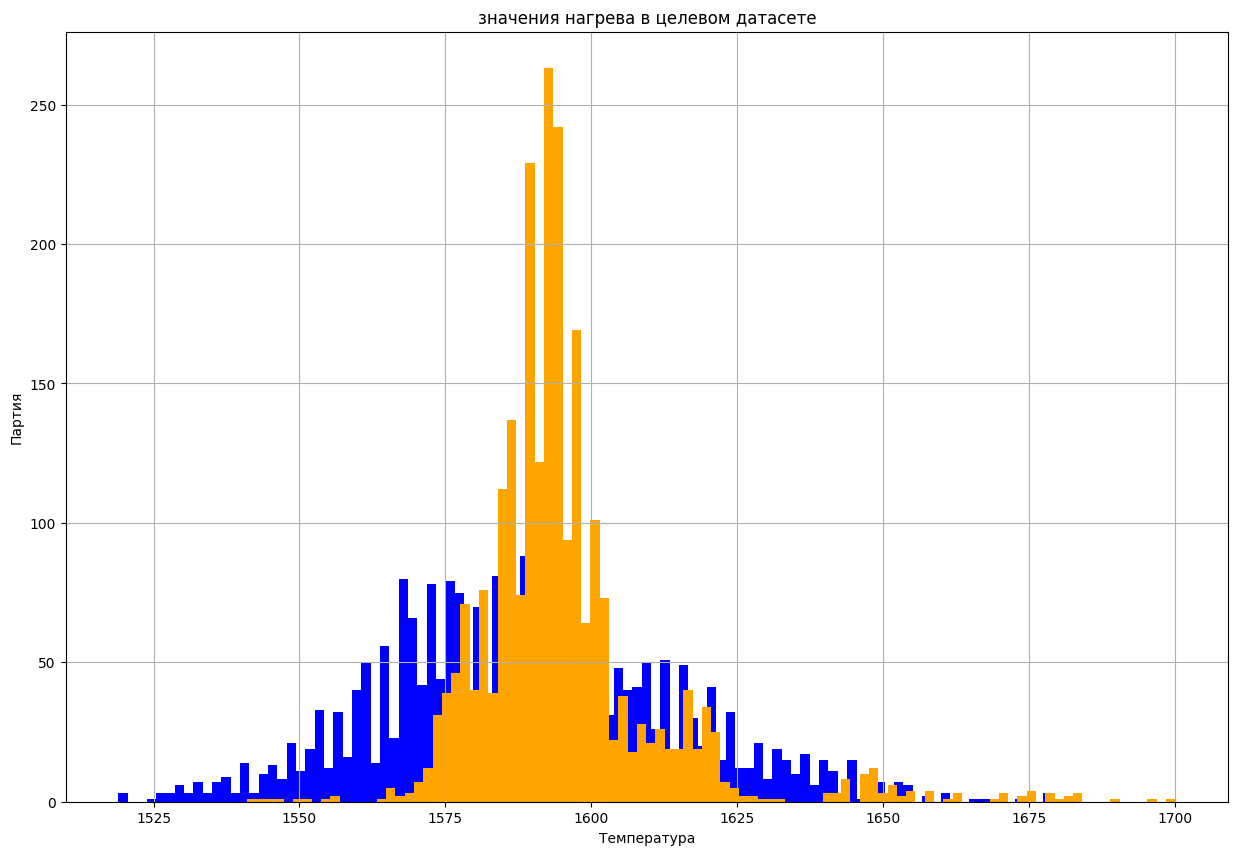

In [94]:
df_target["temp_first"].hist(bins = 100, color='blue')
df_target["temp_last"].hist(bins = 100, color='orange',figsize=(15,10))
plt.title('значения нагрева в целевом датасете')
plt.xlabel('Температура')
plt.ylabel('Партия');

    Есть небольшие выбросы

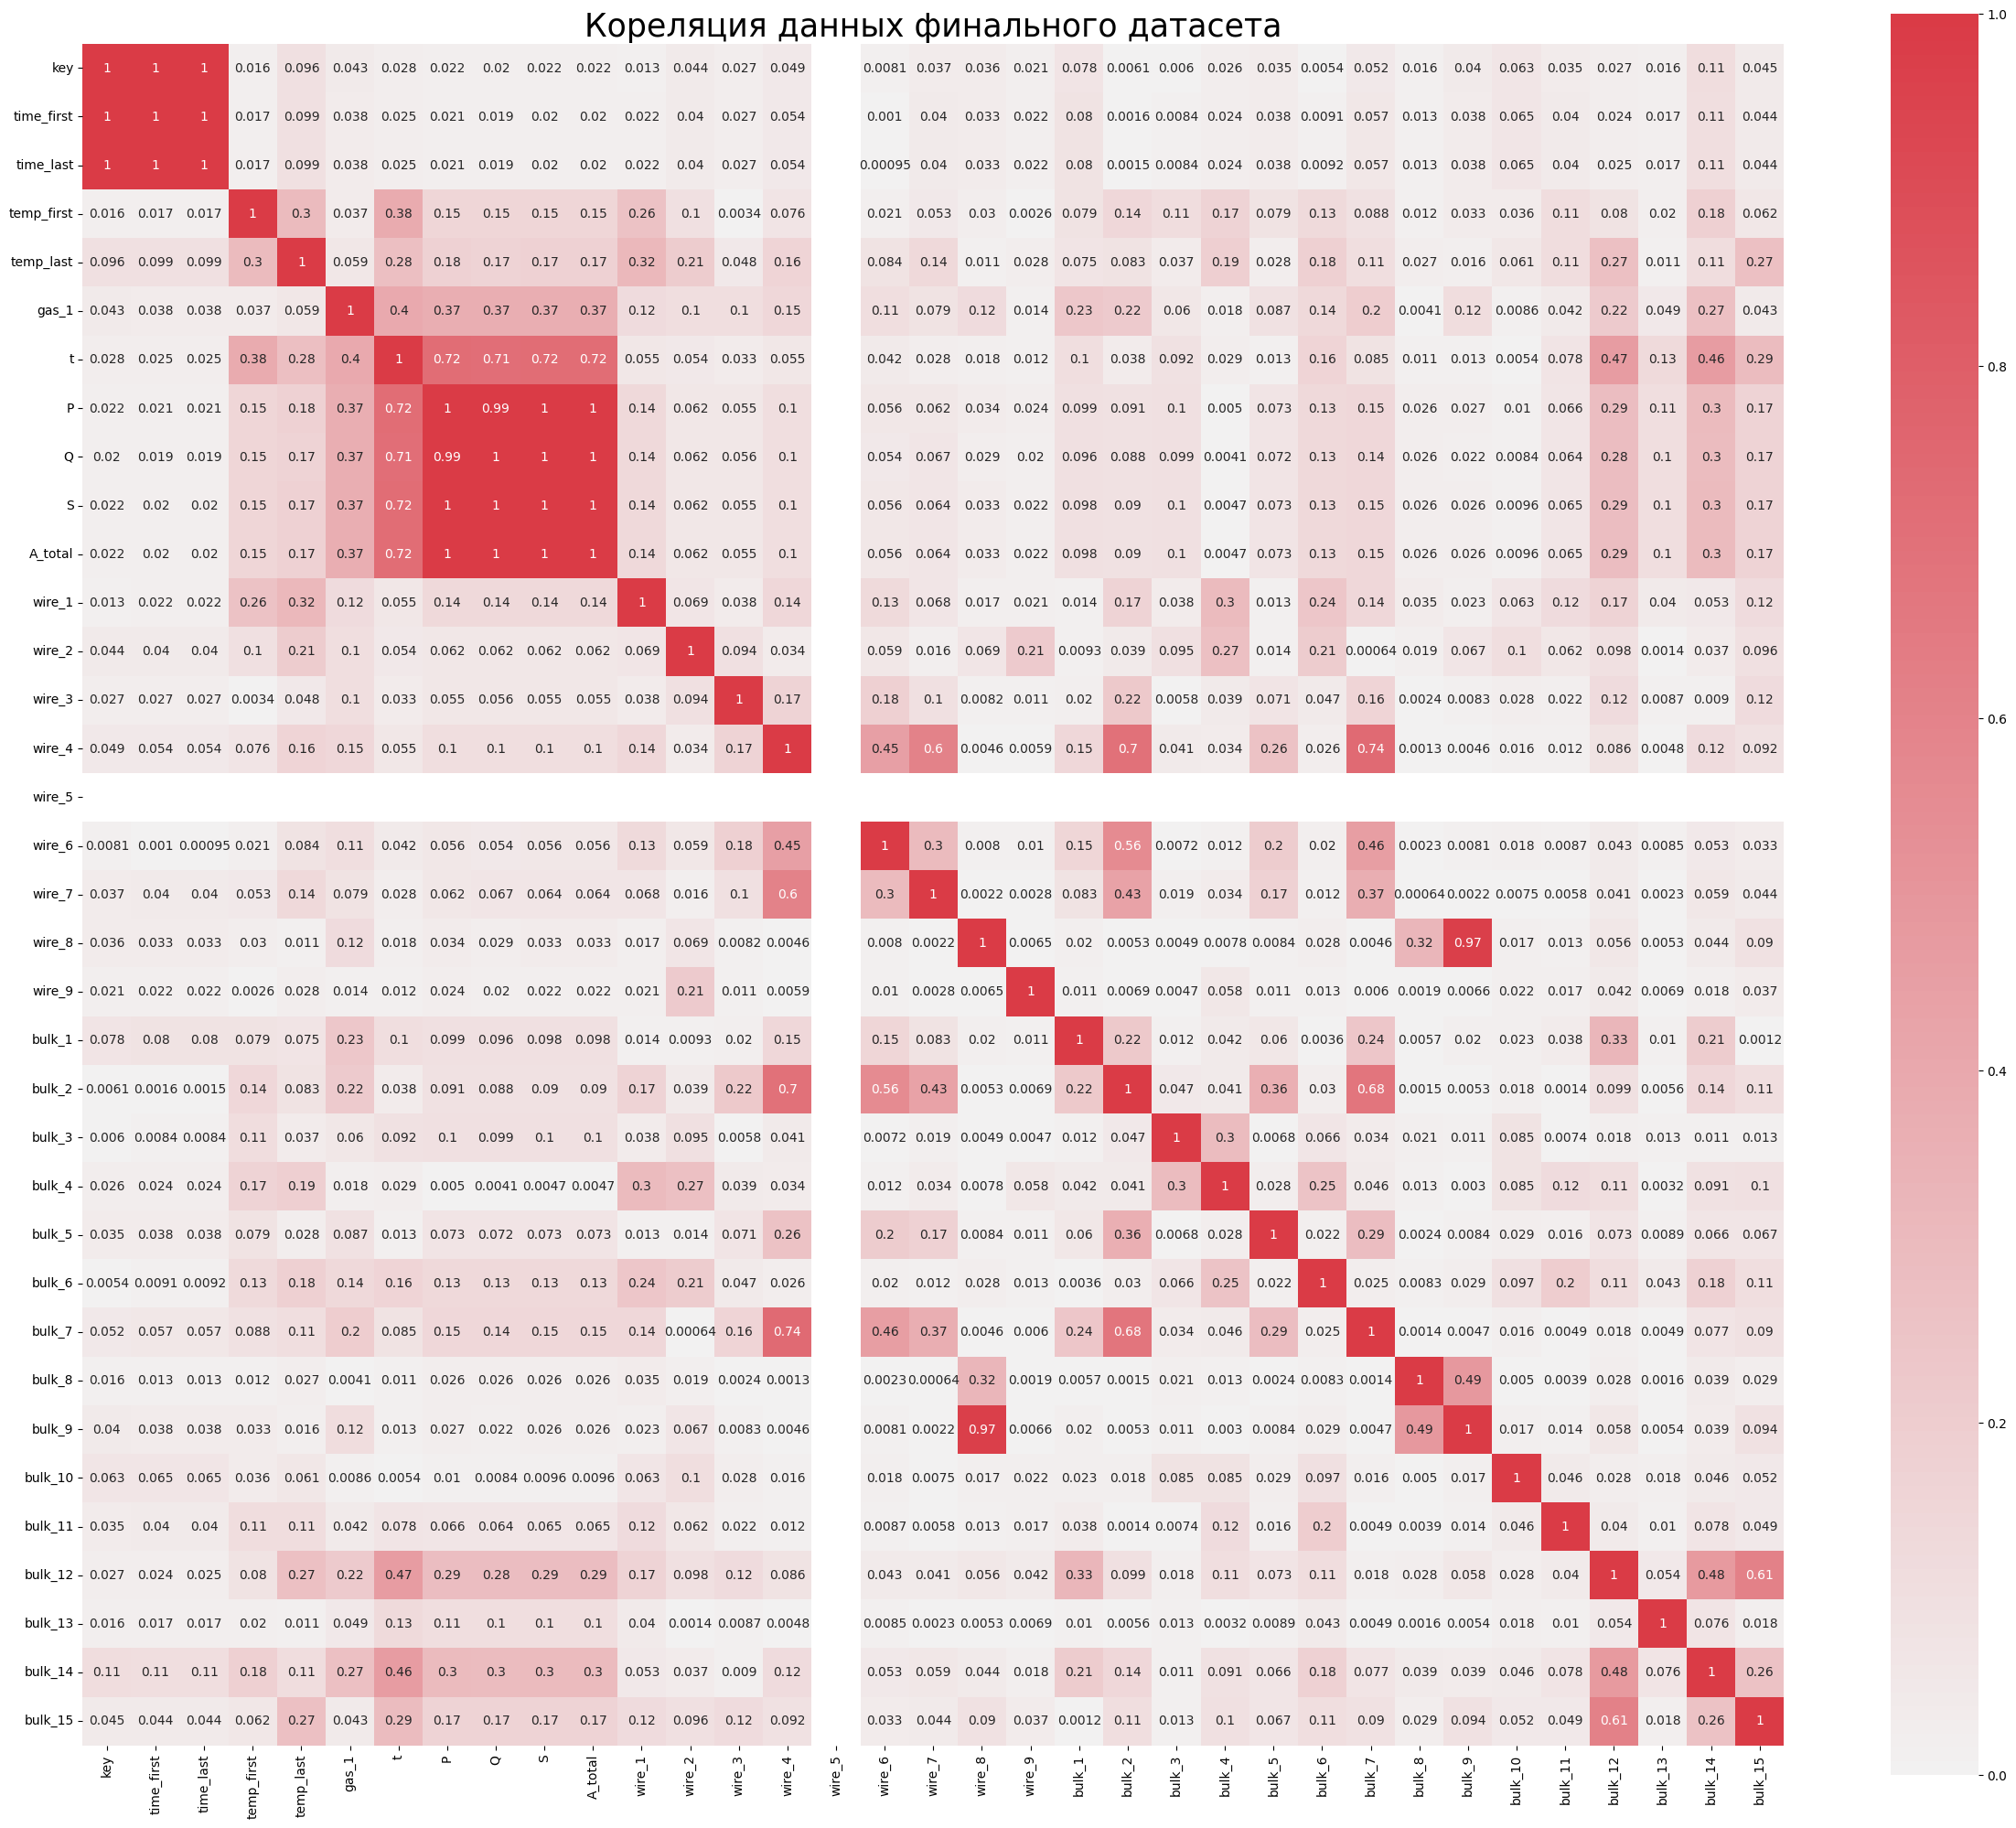

In [95]:
corr = abs(df_final.corr())

f, ax = plt.subplots(figsize=(30, 25))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(200, 10, as_cmap=True)

ax = sns.heatmap(
    corr,
    cmap=cmap,
    annot=True,
    vmax=1,
    vmin=0,
    center=0,
    square=True,
    linewidths=0, 
    xticklabels=True, yticklabels=True
)
plt.title('Кореляция данных финального датасета', size=25);

    Видим пропуск на пятом этапе 'wire'. Его можно будет удалить

    По матрице кореляции видим, что параметры которые содержатся в формуле подсчета A_total максимально взаимосвязаны
    между собой. Оставим только его, а остальные удалим в том числе и номера партий.

In [96]:
df_final = df_final.drop(["S", "Q", "P", "wire_5", "key", "t", 'time_first','time_last'], axis = 1)

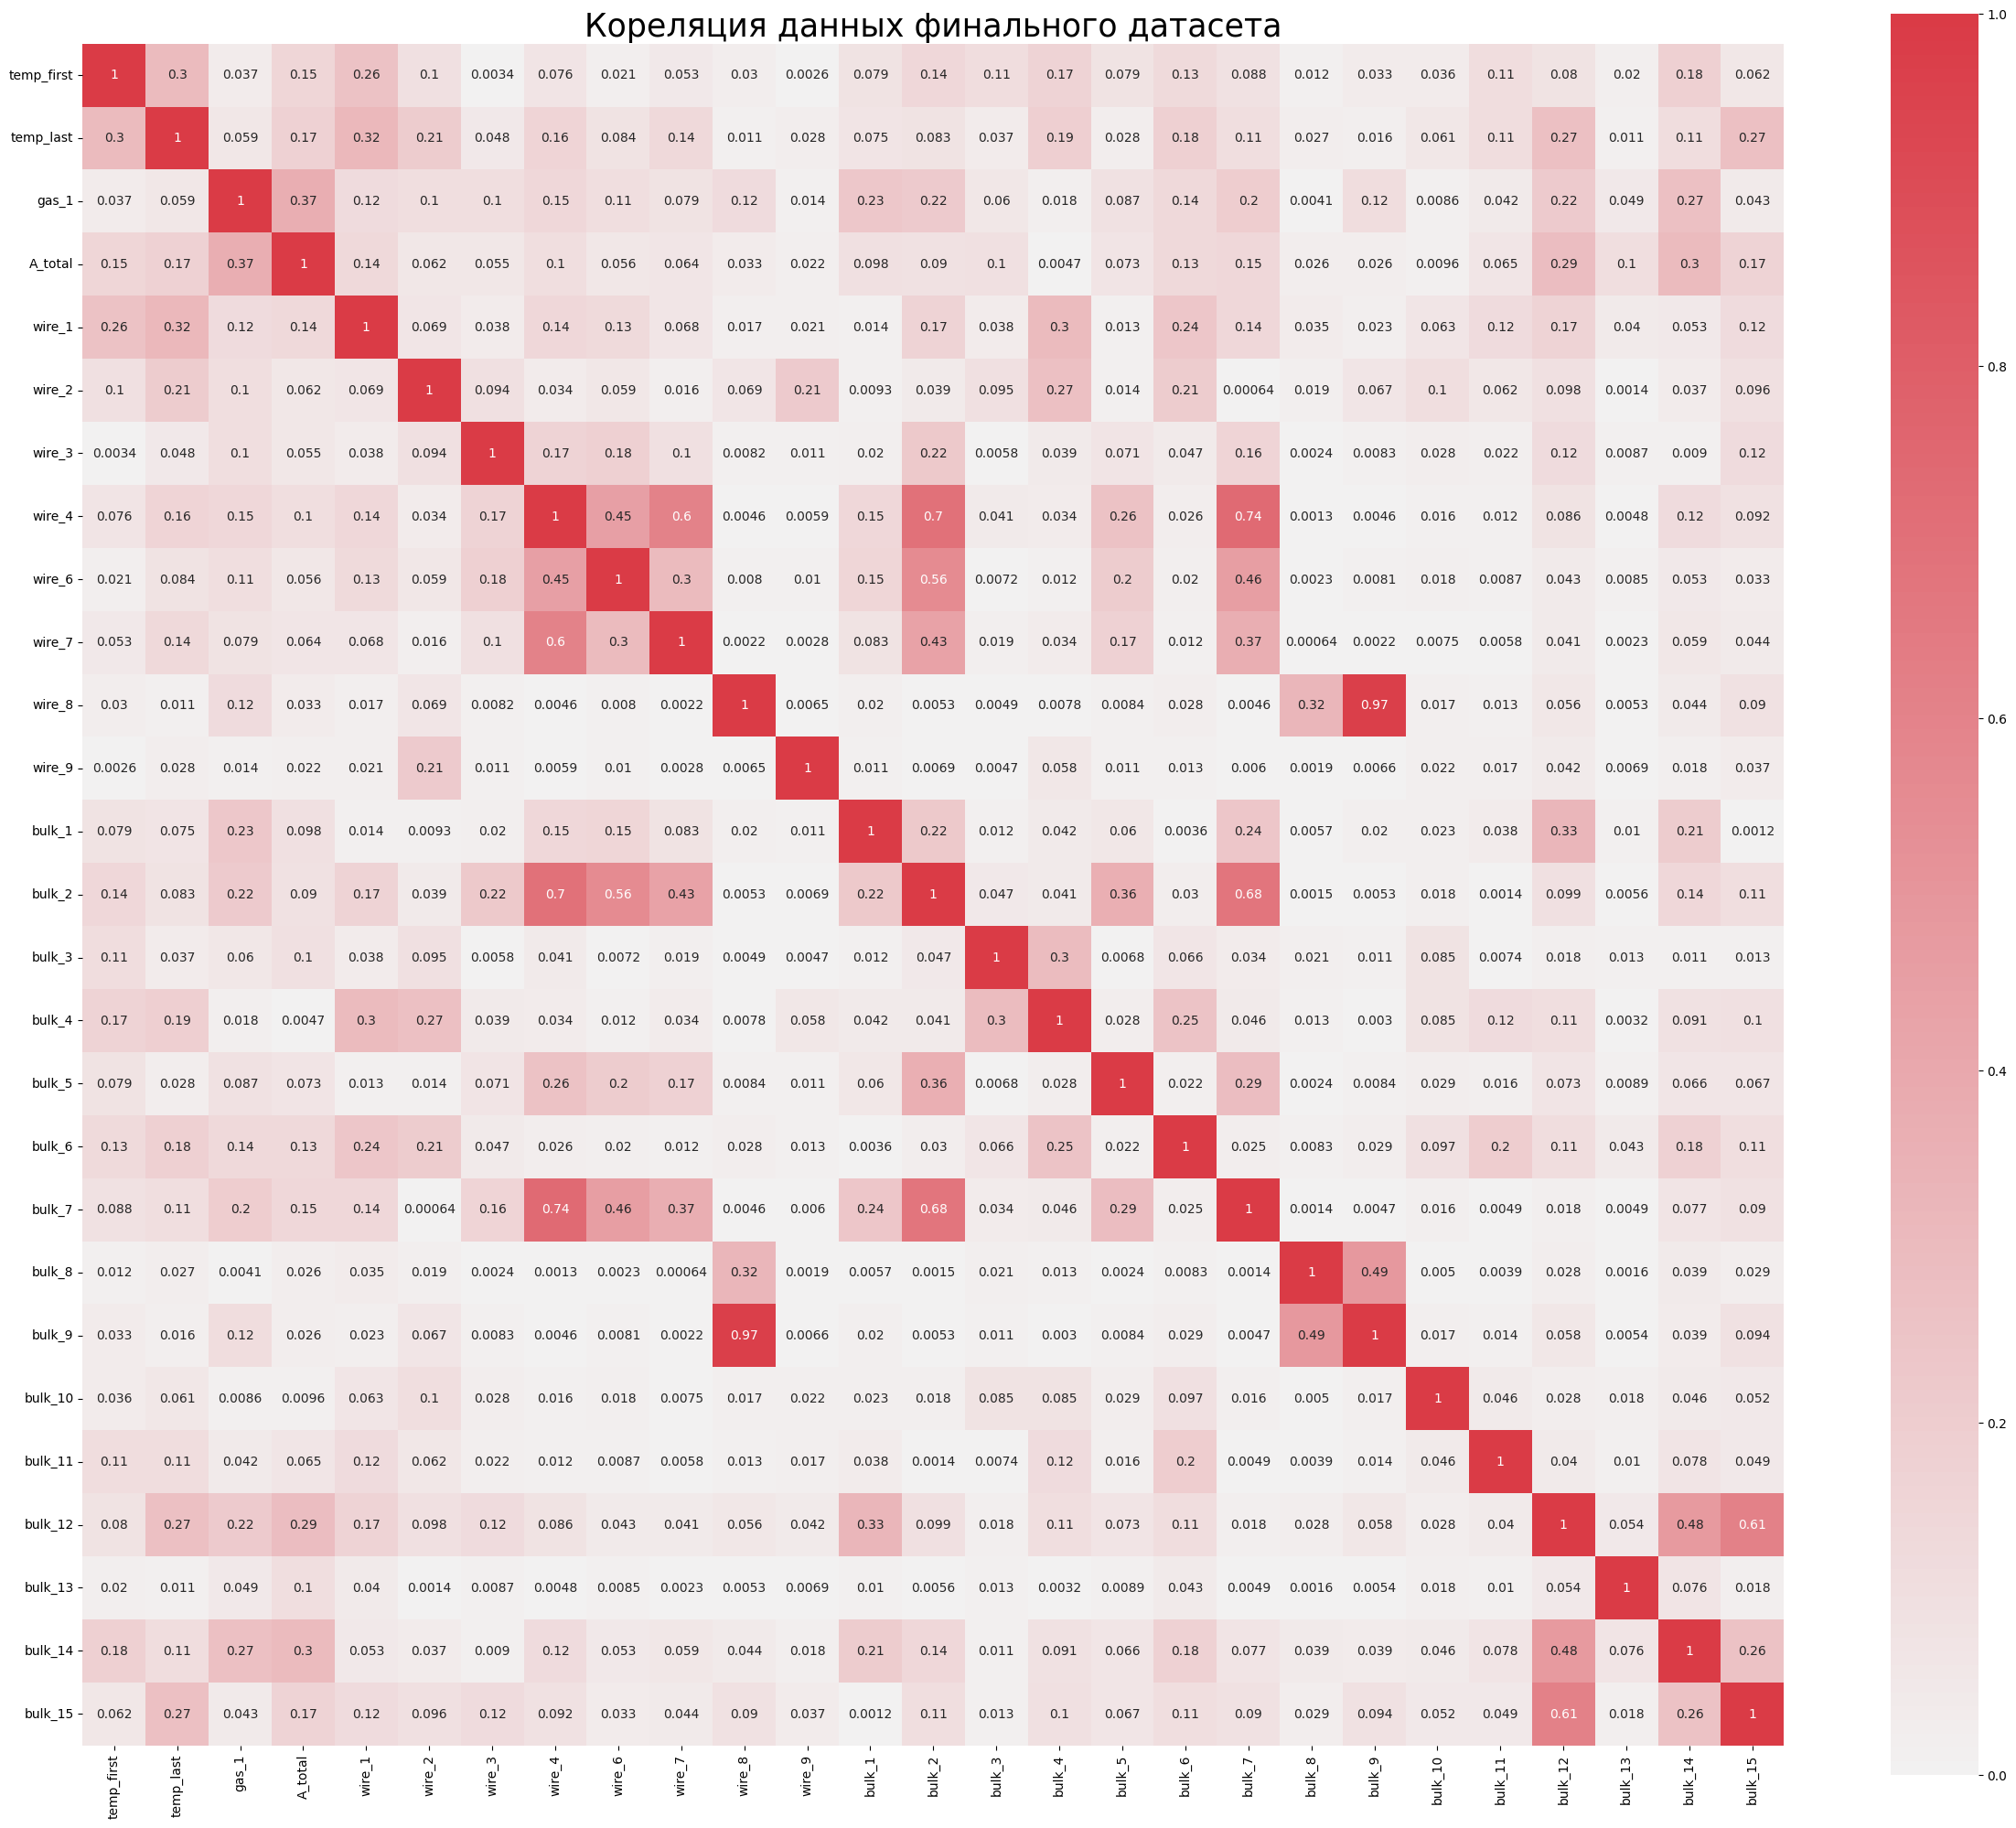

In [97]:
corr = abs(df_final.corr())

f, ax = plt.subplots(figsize=(30, 25))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(200, 10, as_cmap=True)

ax = sns.heatmap(
    corr,
    cmap=cmap,
    annot=True,
    vmax=1,
    vmin=0,
    center=0,
    square=True,
    linewidths=0, 
    xticklabels=True, yticklabels=True
)
plt.title('Кореляция данных финального датасета', size=25);

    Видим что между bulk_9 и wire_8 происходит что-то непонятное. Удалим wire_8

In [98]:
df_final = df_final.drop(['wire_8'], axis = 1)

In [99]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_first  2324 non-null   float64
 1   temp_last   2324 non-null   float64
 2   gas_1       2324 non-null   float64
 3   A_total     2324 non-null   float64
 4   wire_1      2324 non-null   float64
 5   wire_2      2324 non-null   float64
 6   wire_3      2324 non-null   float64
 7   wire_4      2324 non-null   float64
 8   wire_6      2324 non-null   float64
 9   wire_7      2324 non-null   float64
 10  wire_9      2324 non-null   float64
 11  bulk_1      2324 non-null   float64
 12  bulk_2      2324 non-null   float64
 13  bulk_3      2324 non-null   float64
 14  bulk_4      2324 non-null   float64
 15  bulk_5      2324 non-null   float64
 16  bulk_6      2324 non-null   float64
 17  bulk_7      2324 non-null   float64
 18  bulk_8      2324 non-null   float64
 19  bulk_9      2324 non-null  

    Также посмотрим зависимость числовых признаков с температурой

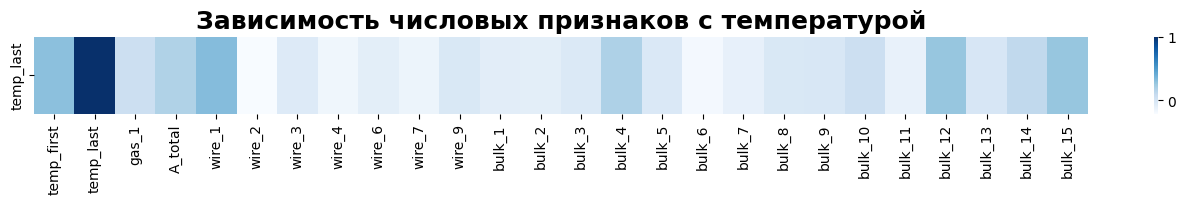

In [100]:
n=df_final.select_dtypes(exclude='object')
ncorr=n.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(ncorr.sort_values(by=['temp_last'], ascending=False).head(1), cmap='Blues')
plt.title("Зависимость числовых признаков с температурой", weight='bold', fontsize=18)
plt.show()

    В целом данные распределены нормально

## Обучение модели

In [101]:
random_state = 310723
train, test = train_test_split(df_final, test_size = 0.25)
cv_counts = 7

In [102]:
print('train:', (train.shape[0]*100) / df_final.shape[0],'%')
print('test:', (test.shape[0]*100) / df_final.shape[0],'%')

train: 75.0 %
test: 25.0 %


In [103]:
train_features = train.drop(['temp_last'], axis = 1)
train_target = train['temp_last']
test_features = test.drop(['temp_last'], axis = 1)
test_target = test['temp_last']

### RandomForestRegressor

In [162]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(50, 701, 50)], 
                'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(train_features, train_target)

# Tuning hyper-parameters for mean_absolute_error

CPU times: total: 4min 52s
Wall time: 4min 52s


GridSearchCV(cv=7, estimator=RandomForestRegressor(),
             param_grid=[{'criterion': ['mse'],
                          'n_estimators': [50, 100, 150, 200, 250, 300, 350,
                                           400, 450, 500, 550, 600, 650, 700],
                          'random_state': [310723]}],
             scoring='neg_mean_absolute_error')

In [163]:
clf.best_estimator_

RandomForestRegressor(criterion='mse', n_estimators=700, random_state=310723)

In [164]:
cv_MAE_RFR = clf.best_score_ * -1
cv_MAE_RFR

7.142296533071058

### CatBoostRegressor

In [165]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             train_features, 
                             train_target, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 7.140638528412189
CPU times: total: 1min 37s
Wall time: 15.3 s


### LGMBRegressor

In [105]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(4,31)], 
                'learning_rate':[x/200 for x in range(1, 21)],
                'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(train_features, train_target)

# Tuning hyper-parameters for mean_absolute_error

CPU times: total: 34min 15s
Wall time: 4min 19s


GridSearchCV(cv=7, estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.005, 0.01, 0.015, 0.02, 0.025,
                                            0.03, 0.035, 0.04, 0.045, 0.05,
                                            0.055, 0.06, 0.065, 0.07, 0.075,
                                            0.08, 0.085, 0.09, 0.095, 0.1],
                          'num_leaves': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                         25, 26, 27, 28, 29, 30],
                          'random_state': [310723]}],
             scoring='neg_mean_absolute_error')

In [106]:
clf.best_estimator_

LGBMRegressor(learning_rate=0.045, num_leaves=17, random_state=310723)

In [107]:
cv_MAE_LGMBR = clf.best_score_ * -1
cv_MAE_LGMBR

7.162170450353825

    Было использованно 3 модели. Лучше всех себя показала LGBMRegressor

## Тестирование модели

In [108]:
target_predict = clf.best_estimator_.predict(test_features)
target_predict.min()

1576.1099034451745

In [109]:
final_MAE_LGMBR = mean_absolute_error(test_target, target_predict)
final_MAE_LGMBR

6.383616536191845

In [110]:
clf.best_params_

{'learning_rate': 0.045, 'num_leaves': 17, 'random_state': 310723}

    1) Проект был выполнен по ранее описанному плану
    
    2) Основные трудности были вызванны:
        - в не правильно оформленных столбцах таблиц (имели не общепринятый вид)
        - отрицательными, пропущенными, а также значениями ниже температуры плавления металла

    3) Были изучены и подготовлены данные
        1.
            - просмотрены все таблицы
            - выявлены аномальные значения
            - выбран целевой признак (последний замер температуры в data_temp)
        2.
            - исправлено оформление столбцов
            - столбцы с датами переведены в формат datetime
            - устранены все аномалии в значениях
            - заполнены проруски в bul, bulk_time, wire, wire_time
            - рассчитана полная мощьность и итоговая работа для данных об электродах
            - сгруппирован целевой датафрейм по партиям(столбец "key")
            - создана финальная таблица для обучения моделей
            - на колрреляционной матрице выявили аномальные факторы для удаления из финальной таблицы
            - создали обучающую и тестовую выборку для моделей
        3.
            - Были обучены 3 модели:
                a) RandomForestRegressor
                b) CatBoostRegressor
                c) LGMBRegressor
            - лучше всех на тренировочной выборке себя показала LGMBRegressor, в следствии была протестирована на тестовой
            выборке и получила MAE = 6.718799654980479
            
    4) Целевым признаком стали данные с последним замером температуры. Для устранения аномалий/пропусков в данных
    выполнили:
        - создали переменную, которая отвечает за количество итераций в партии
        - убрали партии у которых присутсвуют значения ниже температуры плавления (1450 градусов)
        - убрали партии у которых присутсвует только 1 замер температуры
        - убрали партии у которых отсутвует замер температуры
        
    5) Для обучения лучшей модели LGMBRegressor были использованы следующие параметры:
        - cv_counts = 7
        - random_state = 310723
        - param_grid=[{'learning_rate': [0.005, 0.01, 0.015, 0.02, 0.025,
                                            0.03, 0.035, 0.04, 0.045, 0.05,
                                            0.055, 0.06, 0.065, 0.07, 0.075,
                                            0.08, 0.085, 0.09, 0.095, 0.1],
                          'num_leaves': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                         25, 26, 27, 28, 29, 30]}]
        - scoring='neg_mean_absolute_error'
        
    6) Итоговая метрика составила 6.718799654980479, что входит в критерии данные заказчиком
    
    7) В рекомендации могу добавить:
        - проверка данных на стандартность оформления таблиц перед выгрузкой другому специалисту
        - проверить точность и правильность работы приборов нагревающих и замеряющих сырьё

## Итоговый отчёт

    1) Проект был выполнен по ранее описанному плану
    
    2) Основные трудности были вызванны:
        - в не правильно оформленных столбцах таблиц (имели не общепринятый вид)
        - отрицательными, пропущенными, а также значениями ниже температуры плавления металла
       **Столбцы были приведены к стандартному виду, от аномальных значений мы избавились**  

    3) Были изучены и подготовлены данные
        1.
            - просмотрены все таблицы
            - выявлены аномальные значения
            - выбран целевой признак (последний замер температуры в data_temp)
        2.
            - исправлено оформление столбцов
            - столбцы с датами переведены в формат datetime
            - устранены все аномалии в значениях
            - заполнены проруски в bul, bulk_time, wire, wire_time
            - рассчитана полная мощьность и итоговая работа для данных об электродах
            - сгруппирован целевой датафрейм по партиям(столбец "key")
            - создана финальная таблица для обучения моделей
            - на колрреляционной матрице выявили аномальные факторы для удаления из финальной таблицы
            - создали обучающую и тестовую выборку для моделей
        3.
            - Были обучены 3 модели:
                a) RandomForestRegressor
                b) CatBoostRegressor
                c) LGMBRegressor
            - лучше всех на тренировочной выборке себя показала LGMBRegressor, в следствии была протестирована на тестовой
            выборке и получила MAE = 6.718799654980479
            
    4) Целевым признаком стали данные с последним замером температуры. Для устранения аномалий/пропусков в данных
    выполнили:
        - создали переменную, которая отвечает за количество итераций в партии
        - убрали партии у которых присутсвуют значения ниже температуры плавления (1450 градусов)
        - убрали партии у которых присутсвует только 1 замер температуры
        - убрали партии у которых отсутвует замер температуры

In [104]:
train_features.head()

,temp_first,gas_1,A_total,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1285,1599.0,10.126385,3007.529634,197.823594,15.110160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0,0.0,121.0,204.0
147,1597.0,10.393855,1019.621874,45.121437,20.092800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,1582.0,18.405101,6268.306631,149.151613,9.138480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,388.0,0.0,214.0,183.0
1508,1567.0,10.647530,3399.631304,117.327598,42.525600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2207,1540.0,7.716934,4095.170661,0.000000,100.674072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,124.0,0.0,216.0,104.0


In [111]:
train_target.head()

1285    1619.0
147     1578.0
485     1616.0
1508    1580.0
2207    1569.0
Name: temp_last, dtype: float64

    5) Для обучения лучшей модели LGMBRegressor были использованы следующие параметры:
        - cv_counts = 7
        - random_state = 310723
      **- hyperparams = [{'num_leaves':[x for x in range(4,31)], 
                'learning_rate':[x/200 for x in range(1, 21)],
                'random_state':[random_state]}]**
        - param_grid=[{'learning_rate': [0.005, 0.01, 0.015, 0.02, 0.025,
                                            0.03, 0.035, 0.04, 0.045, 0.05,
                                            0.055, 0.06, 0.065, 0.07, 0.075,
                                            0.08, 0.085, 0.09, 0.095, 0.1],
                          'num_leaves': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                         25, 26, 27, 28, 29, 30]}]
        - scoring='neg_mean_absolute_error'
        
      !!- лучшие параметры модели {'learning_rate': 0.045, 'num_leaves': 17, 'random_state': 310723} !!
        
    6) Итоговая метрика составила 6.718799654980479, что входит в критерии данные заказчиком
    
    7) В рекомендации могу добавить:
        - проверка данных на стандартность оформления таблиц перед выгрузкой другому специалисту
        - проверить точность и правильность работы приборов нагревающих и замеряющих сырьё